# QQ Plot

In this notebook we provide visual diagnostic to examine the normality of our prediction.

## Helper Cells

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath("../src"))
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm
from tqdm import tqdm
from itertools import product
from sklearn.model_selection import ParameterSampler
from BRAT.algorithms import BRATD, BRATP

In [3]:
plt.style.use('../matplotlibrc')
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [4]:
import matplotlib.colors as mcolors

def darken(color, factor=0.7):
    """
    Darken a hex color by multiplying its RGB components by `factor` (0 < factor < 1).
    """
    rgb = np.array(mcolors.to_rgb(color))
    darker = np.clip(rgb * factor, 0, 1)
    return mcolors.to_hex(darker)

## Model Fitting and Prediction

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def qqplot_rstyle(
    z,
    ax=None,
    line='quartiles',
    ci=0.0,
    n_sim=1000,
    fontsize=6,
    marker_kwargs=None,
    line_kwargs=None,
    ci_kwargs=None,
    equal_units=True,
    diag=True,
    diag_kwargs=None
):
    z = np.asarray(z)
    z = z[np.isfinite(z)]
    if z.size < 3:
        raise ValueError("Not enough finite Z values to draw a QQ plot.")

    z_sorted = np.sort(z)
    n = len(z_sorted)
    probs = (np.arange(1, n + 1) - 0.5) / n
    theo_q = stats.norm.ppf(probs)

    if line == 'quartiles':
        q_sample = np.quantile(z_sorted, [0.25, 0.75])
        q_theor = stats.norm.ppf([0.25, 0.75])
        slope = (q_sample[1] - q_sample[0]) / (q_theor[1] - q_theor[0])
        intercept = q_sample[0] - slope * q_theor[0]
    else:
        slope, intercept, *_ = stats.linregress(theo_q, z_sorted)

    if ci > 0:
        sims = np.random.normal(size=(n_sim, n))
        sims.sort(axis=1)
        lo = (1 - ci) / 2
        hi = 1 - lo
        low_env = np.percentile(sims, lo * 100, axis=0)
        high_env = np.percentile(sims, hi * 100, axis=0)
    else:
        low_env = high_env = None

    if ax is None:
        fig, ax = plt.subplots(figsize=(2.2, 2.2), dpi=300)
    else:
        fig = ax.figure

    # Use first three distinct colors from the current color cycle
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_dot = color_cycle[0]
    color_fit = color_cycle[1] if len(color_cycle) > 1 else color_dot
    color_diag = color_cycle[2] if len(color_cycle) > 2 else color_dot

    if marker_kwargs is None:
        marker_kwargs = dict(marker='o', mfc='none', mec=color_dot, color=color_dot, ms=2, lw=0, linestyle='None')
    if line_kwargs is None:
        line_kwargs = dict(color=color_fit, lw=0.8)
    if ci_kwargs is None:
        ci_kwargs = dict(color=color_dot, alpha=0.2, linewidth=0)
    if diag_kwargs is None:
        diag_kwargs = dict(color=color_diag, linestyle='--', lw=0.6)

    if ci > 0:
        ax.fill_between(theo_q, low_env, high_env, **ci_kwargs)

    ax.plot(theo_q, z_sorted, **marker_kwargs)
    ax.plot(theo_q, slope * theo_q + intercept, **line_kwargs)

    if equal_units:
        lo = min(ax.get_xlim()[0], ax.get_ylim()[0])
        hi = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_aspect('equal', adjustable='box')

    if diag:
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        lo = max(x0, y0)
        hi = min(x1, y1)
        if lo < hi:
            xx = np.linspace(lo, hi, 200)
            ax.plot(xx, xx, **diag_kwargs)

    ax.set_xlabel("Theoretical Quantiles", fontsize=fontsize)
    ax.set_ylabel("Sample Quantiles", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    ax.set_title("QQ Plot", fontsize=fontsize + 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return fig, ax


In [6]:
def quadratic(n, a=1, b=0, c=0):
    X = np.random.uniform(0, 5, n)
    eps = np.random.normal(0, 1, n)
    y = a * X**2 + b * X + c + eps
    return X, y

In [7]:
def singleBRAT(config, x, n, a, b, c, use_bratd=True, nys_rate=0.2):
    # Pick algorithm
    model = BRATD(**config) if use_bratd else BRATP(**config)

    # Generate data (reshape to 2D for the model)
    X, y = quadratic(n, a=a, b = b, c = c)
    X = X.reshape(-1, 1)
    from sklearn.model_selection import train_test_split
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

    model.fit(X_tr, y_tr, X_te, y_te)

    # Force x to 2D for predict
    x2d = np.array(x, ndmin=2).reshape(1, -1)
    pred = model.predict(x2d)
    pred = float(np.asarray(pred).reshape(-1)[0])  # <-- scalar

    # Get ||r||_2
    model.unif_nystrom(0.2)        # or pass nys_rate
    model.sketch_K()
    sigmahat2 = model.est_sigma_hat2(in_bag=False)
    sigmahat = np.sqrt(sigmahat2)
    r_raw = model.sketch_r(x2d[0])  # returns norm
    r_norm = float(np.asarray(r_raw).reshape(-1)[0])  # <-- scalar

    return pred, r_norm, sigmahat


In [8]:
def multipleBRAT(config, B, x, n, use_bratd=True,
                a=1, b=2, c=1, nys_rate=0.1):
    preds, rnorms = [], []
    for _ in range(B):
        p, rn, sigmahat = singleBRAT(config, x, n, a = a, b = b, c = c,
                                    use_bratd=use_bratd, nys_rate=nys_rate)
        preds.append(p)
        rnorms.append(rn)

    preds  = np.array(preds,  dtype=float)
    rnorms = np.array(rnorms, dtype=float)

    # Theoretical center μ(x)
    lam = config['learning_rate']
    dropout = config.get('dropout_rate', 0.0)
    q = 1 - dropout
    f_true = a * x**2 + b * x + c
    mu = f_true

    eps = 1e-12  # avoid divide-by-zero
    tauhat = sigmahat * rnorms * ((1 + lam * q) / lam)
    Z = (preds - mu) / tauhat + eps
    return Z, preds, rnorms


In [9]:
# Run MC
config = dict(
    n_estimators=100,
    learning_rate=0.8,
    max_depth=8,
    subsample_rate=0.4,
    dropout_rate=0.2,
    disable_tqdm=True
)
x_eval = 2.0  # pick a fixed point in [0,5]
Z, preds, rnorms = multipleBRAT(config, B=100, x=x_eval, n=1000, use_bratd=True)
Z = Z[np.isfinite(Z)]
if Z.size < 3:
    raise ValueError("Too few finite Z values to plot.")

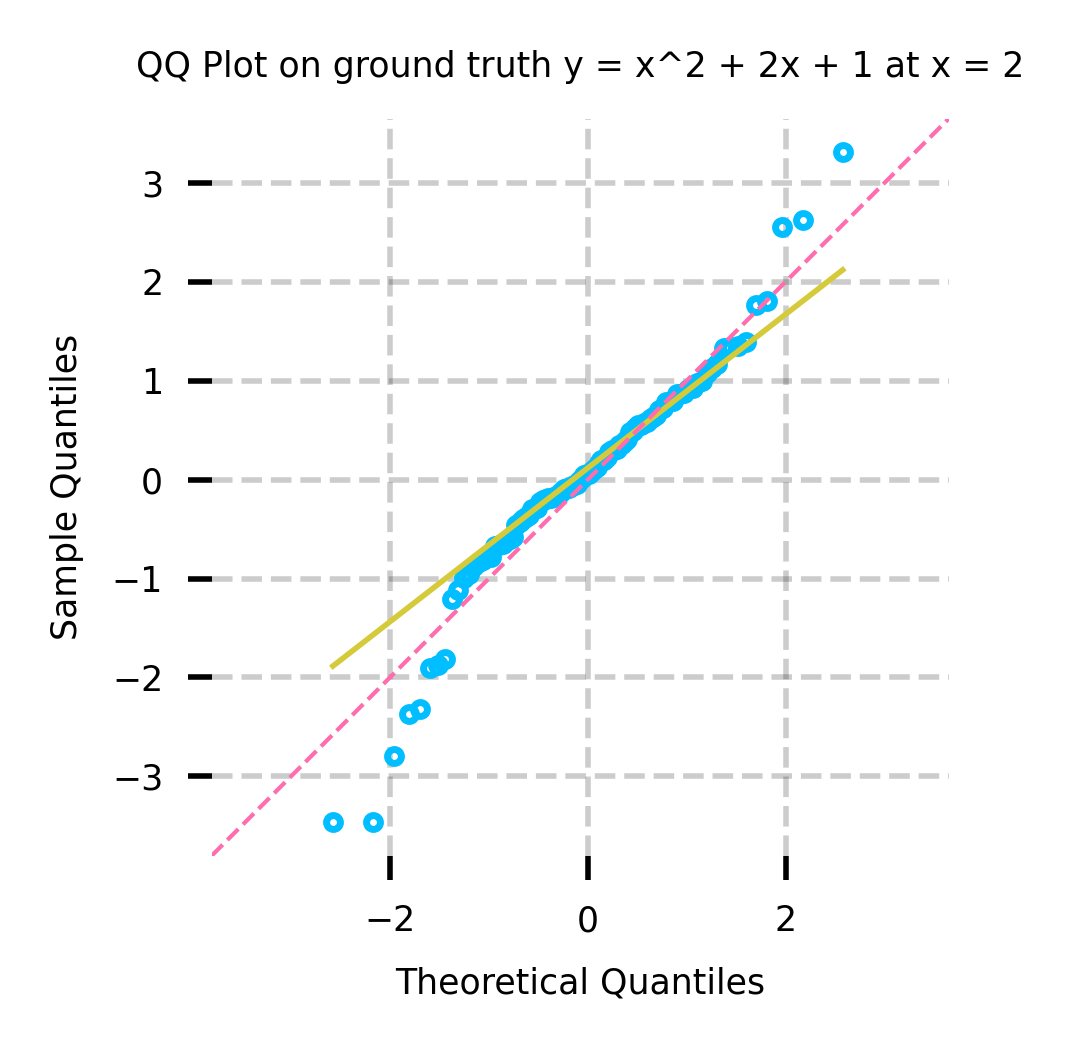

In [10]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), dpi=500)
qqplot_rstyle(
    Z, ax=ax,
    line='quartiles',
    ci=0.0,
    fontsize=5,
    diag=True,
    equal_units=True
)
ax.set_title(f"QQ Plot on ground truth y = x^2 + 2x + 1 at x = 2", fontsize=5)
fig.tight_layout()
fig.savefig("qq_bratd")
plt.show()

In [11]:
# ————————————————————————————————
# Shapiro–Wilk test for normality of Z
# ————————————————————————————————
from scipy.stats import shapiro

# Z is your standardized residuals array from multipleBRAT
W, p_value = shapiro(Z)

print("Shapiro–Wilk test for Z:")
print(f"  W statistic = {W:.4f}")
print(f"  p‑value     = {p_value:.4e}")

alpha = 0.05
if p_value > alpha:
    print(f"  → p > {alpha}: fail to reject H₀ (no evidence against normality)")
else:
    print(f"  → p ≤ {alpha}: reject H₀ (deviation from normality detected)")


Shapiro–Wilk test for Z:
  W statistic = 0.9472
  p‑value     = 5.4362e-04
  → p ≤ 0.05: reject H₀ (deviation from normality detected)


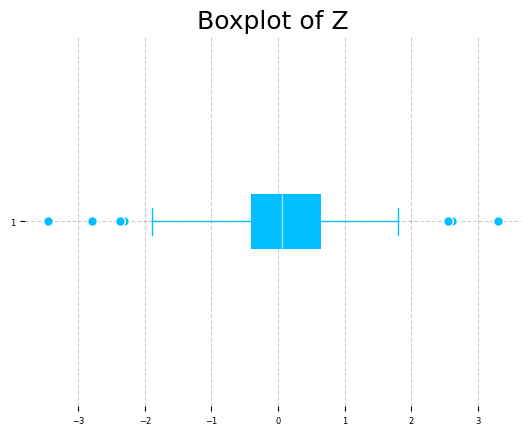

Shapiro-Wilk: W = 0.9472, p = 0.0005


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats.mstats import winsorize

# 1a) Quick boxplot to spot extremes
plt.boxplot(Z, vert=False)
plt.title("Boxplot of Z")
plt.show()

# 1b) Trim everything beyond ±2σ
mask = np.abs(Z) <= 0
Z_trim = Z[mask]

# 1c) Re-run Shapiro–Wilk on the trimmed data
W, p = shapiro(Z)
print(f"Shapiro-Wilk: W = {W:.4f}, p = {p:.4f}")


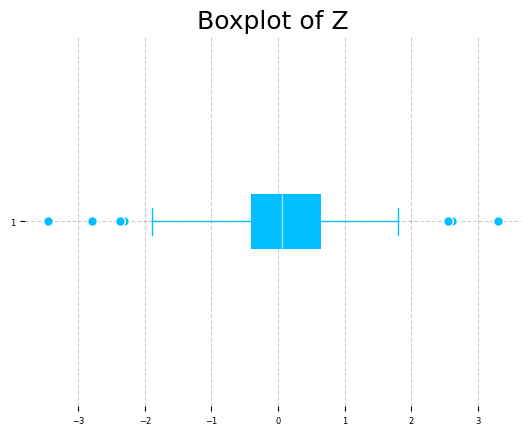

Removed 8 outliers beyond 2sigma
Trimmed Shapiro-Wilk: W = 0.9876, p = 0.5431


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats.mstats import winsorize

# 1a) Quick boxplot to spot extremes
plt.boxplot(Z, vert=False)
plt.title("Boxplot of Z")
plt.show()

# 1b) Trim everything beyond ±2σ
mask = np.abs(Z) <= 2
Z_trim = Z[mask]
print(f"Removed {len(Z) - len(Z_trim)} outliers beyond 2sigma")

# 1c) Re-run Shapiro–Wilk on the trimmed data
W_trim, p_trim = shapiro(Z_trim)
print(f"Trimmed Shapiro-Wilk: W = {W_trim:.4f}, p = {p_trim:.4f}")


In [30]:
import numpy as np
from scipy.stats import jarque_bera

# --- Untrimmed JB test ---
jb_stat, jb_p = jarque_bera(Z)
print("Untrimmed Jarque–Bera test:")
print(f"  JB statistic = {jb_stat:.4f}")
print(f"  p‑value      = {jb_p:.4e}")
print("  →", "fail to reject normality" if jb_p > 0.05 else "reject normality", "\n")

# --- ±2σ trimming ---
sigma_thresh = 2.0
mask      = np.abs(Z) <= sigma_thresh
Z_trimmed = Z[mask]
jb_t, jb_p_t = jarque_bera(Z_trimmed)
print(f"Trimmed JB test (|Z| ≤ {sigma_thresh}σ):")
print(f"  kept {Z_trimmed.size}/{Z.size} points")
print(f"  JB statistic = {jb_t:.4f}")
print(f"  p‑value      = {jb_p_t:.4e}")
print("  →", "fail to reject normality" if jb_p_t > 0.05 else "reject normality")


Untrimmed Jarque–Bera test:
  JB statistic = 20.9855
  p‑value      = 2.7736e-05
  → reject normality 

Trimmed JB test (|Z| ≤ 2.0σ):
  kept 92/100 points
  JB statistic = 1.0995
  p‑value      = 5.7709e-01
  → fail to reject normality
